<a href="https://colab.research.google.com/github/google/business_intelligence_group/blob/main/solutions/causal-impact/CausalImpact_with_Experimental_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CausalImpact with Experimental Design**

This Colab file contains..

*Experimental Design*
* Load Data
* Experimental Design
* Simulation

*CausalImpact Analysis*
* Load Data
* CausalImpact Analysis

See README.md for details

---

Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Experimental Design Section

The experimental design section consists of pre-processing, experimental design, and simulation.

In [1]:
#@title Step1: Define PreProcess
#@markdown Please <font color='red'><b>run this cell</b></font> to define class PreProcess
class PreProcess(object):
  """PreProcess read, format, and check the data needed

  before Experimental Design.

  Attributes:
    load_data_from_sheet: Read data from spreadsheet.
    load_data_from_csv: Read data from CSV.
    shape_wide: Pivots the data in the specified column.
    trend_check: Visualize series data.
    _get_converted_multi_columns: Column Name Concatenation.
  """

  def __init__(self):
    pass

  def load_data_from_sheet(self, spreadsheet_url, sheet_name):
    """load_data_from_sheet read data from spreadsheet.

    Args:
      spreadsheet_url: Spreadsheet url with data.
      sheet_name: Sheet name with data.
    """
    self._workbook = gc.open_by_url(spreadsheet_url)
    self._worksheet = self._workbook.worksheet(sheet_name)
    self.df_sheet = pd.DataFrame(self._worksheet.get_all_values())
    self.df_sheet.columns = list(self.df_sheet.loc[0, :])
    self.df_sheet.drop(0, inplace=True)
    self.df_sheet.reset_index(drop=True, inplace=True)
    self.df_sheet = self.df_sheet.apply(pd.to_numeric, errors='ignore')
    self.df_sheet.replace(',', '', regex=True, inplace=True)

    self.tb_sheet = widgets.TabBar(['head', 'dtypes', 'describe'])
    with self.tb_sheet.output_to('head'):
      display(self.df_sheet.head(10))
    with self.tb_sheet.output_to('dtypes'):
      display(pd.DataFrame(self.df_sheet.dtypes, columns=['dtypes']))
    with self.tb_sheet.output_to('describe'):
      display(self.df_sheet.describe(include='all'))
    with self.tb_sheet.output_to('head'):
      pass

  def load_data_from_csv(self, csv_name):
    """load_data_from_csv read data from csv.

    Args:
      csv_name: csv file name.
    """
    uploaded = files.upload()
    self.df_sheet = pd.read_csv(io.BytesIO(uploaded[csv_name]))
    self.df_sheet = self.df_sheet.apply(pd.to_numeric, errors='ignore')
    self.df_sheet.replace(',', '', regex=True, inplace=True)

    self.tb_sheet = widgets.TabBar(['head', 'dtypes', 'describe'])
    with self.tb_sheet.output_to('head'):
      display(self.df_sheet.head(10))
    with self.tb_sheet.output_to('dtypes'):
      display(pd.DataFrame(self.df_sheet.dtypes, columns=['dtypes']))
    with self.tb_sheet.output_to('describe'):
      display(self.df_sheet.describe(include='all'))
    with self.tb_sheet.output_to('head'):
      pass

  def shape_wide(self, date_column, pivot_column, kpi_column):
    """shape_wide pivots the data in the specified column.

    Converts long data to wide data suitable for experiment design using
    fastDTW.

    Args:
      date_column: Date column name.
      pivot_column: Columns name that are pivot keys for regions, etc.
      kpi_column: KPI column name.
    """
    self._group_cols = []
    if pivot_column.count(',') == 0:
      self._group_cols.append(pivot_column)
    else:
      self._group_cols = pivot_column.replace(' ', '').split(',')

    self.df_sheet = self.df_sheet[[date_column, kpi_column, *self._group_cols
                                  ]].groupby([date_column, *self._group_cols
                                             ]).sum().reset_index()
    self.df_sheet = pd.pivot_table(
        self.df_sheet, index=date_column, columns=self._group_cols)
    self.df_sheet.columns = self.df_sheet.columns.droplevel(0)
    if len(self.df_sheet.columns.names) == 1:
      pass
    else:
      self.df_sheet.columns = self._get_converted_multi_columns(self.df_sheet)

    self.df_sheet.index = pd.to_datetime(self.df_sheet.index)
    self.df_sheet.index.rename('date', inplace=True)
    self.df_sheet.fillna(0, inplace=True)

  def _get_converted_multi_columns(self, df):
    return [col[0] + '_' + col[1] for col in df.columns.values]

  def trend_check(self, dataframe_wide):
    """trend_check visualize daily trend, 7-day moving average

    Args:
      dataframe_wide: Wide data to check the trend
    """
    self._df_long = pd.melt(
        dataframe_wide.reset_index(),
        id_vars='date').groupby('date').sum().reset_index()
    self._line = alt.Chart(self._df_long).mark_line().encode(
        x=alt.X('date', axis=alt.Axis(title='')),
        y=alt.Y('value:Q', axis=alt.Axis(title='kpi')),
        color=alt.value('#4285F4'))
    self._moving_average = alt.Chart(self._df_long).transform_window(
        rolling_mean='mean(value)',
        frame=[-7, 0],
    ).mark_line().encode(
        x=alt.X('date'), y=alt.Y('rolling_mean:Q'), color=alt.value('#DB4437'))

    self._df_scaled = dataframe_wide.copy()
    for column in self._df_scaled:
      self._df_scaled[column] = (
          self._df_scaled[column] - self._df_scaled[column].min()) / (
              self._df_scaled[column].max() - self._df_scaled[column].min())

    self._df_scaled_cols = list(self._df_scaled.columns)
    self._each = alt.Chart(self._df_scaled.reset_index()).transform_fold(
        self._df_scaled_cols, as_=['pivot', 'kpi']).mark_line().encode(
            alt.X('date:T', title=None, axis=alt.Axis(grid=False)),
            alt.Y('kpi:Q', stack=None, axis=None), alt.Color('pivot:N'),
            alt.Row(
                'pivot:N',
                title=None,
                header=alt.Header(labelAngle=0, labelAlign='left'))).properties(
                    bounds='flush',
                    height=50).configure_facet(spacing=0).configure_view(
                        stroke=None).configure_title(anchor='end')

    self._tb_trend = widgets.TabBar(['all', 'each', 'describe'])
    with self._tb_trend.output_to('all'):
      display((self._line + self._moving_average).properties(
          width=800,
          height=400,
          title={
              'text': ['Daily Trend(blue) & 7days moving average(red)'],
          }))
    with self._tb_trend.output_to('each'):
      display((self._each).properties(width=800))
    with self._tb_trend.output_to('describe'):
      display(dataframe_wide.describe(include='all'))
    with self._tb_trend.output_to('all'):
      pass

print('Done')

Done


In [2]:
#@title Step2
#@markdown Please <font color='red'><b>run this cell</b></font> to select the required items.<br>Then you will see the input fields.

from google.colab import auth
from google.colab import files
from google.colab import widgets
from google.auth import default

from IPython.display import display
from IPython.display import Markdown
from oauth2client.client import GoogleCredentials

import altair as alt
import gspread
import io
import ipywidgets
import pandas as pd

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

soure_selection = ipywidgets.ToggleButtons(
    options=['google_spreadsheet', 'csv'],
    value='google_spreadsheet',
    description='data source:',
    disabled=False,
)
sheet_url = ipywidgets.Text(
    placeholder='Please enter google spreadsheet url',
    value='https://docs.google.com/spreadsheets/d/1dISrbX1mZHgzpsIct2QXFOWWRRJiCxDSmSzjuZz64Tw/edit#gid=0',
    description='sheet url:',
    disabled=False,
    layout=ipywidgets.Layout(width='1000px'))
sheet_name = ipywidgets.Text(
    placeholder='Please enter sheet name',
    value='RawData',
    description='sheet name:',
    disabled=False,
)
csv_name = ipywidgets.Text(
    placeholder='Please enter csv name',
    description='csv name:',
    disabled=False,
    layout=ipywidgets.Layout(width='500px'))
display(soure_selection)
display(
    Markdown(f"""<br>If you select <b>google_spreadsheet</b>,
"""), sheet_url, sheet_name, Markdown(f"""<br>If you select <b>csv</b>,
"""), csv_name)

ToggleButtons(description='data source:', options=('google_spreadsheet', 'csv'), value='google_spreadsheet')

<br>If you select <b>google_spreadsheet</b>,


Text(value='https://docs.google.com/spreadsheets/d/1dISrbX1mZHgzpsIct2QXFOWWRRJiCxDSmSzjuZz64Tw/edit#gid=0', d…

Text(value='RawData', description='sheet name:', placeholder='Please enter sheet name')

<br>If you select <b>csv</b>,


Text(value='', description='csv name:', layout=Layout(width='500px'), placeholder='Please enter csv name')

In [3]:
#@title Step3
#@markdown Once you have entered the above, please <font color='red'><b>run this cell</b></font> to load the file. <br> Next, please fill in the required fields in the format below.

case = PreProcess()
if soure_selection.value == 'google_spreadsheet':
  try:
    case.load_data_from_sheet(
        spreadsheet_url=sheet_url.value, sheet_name=sheet_name.value)
  except:
    print('Please check the entries in the previous cell.')
else:
  try:
    case.load_data_from_csv(csv_name=csv_name.value)
  except:
    print('Please check the entries in the previous cell.')

data_type_selection = ipywidgets.ToggleButtons(
    options=['Longer', 'Wider'],
    description='data type:',
    disabled=False,
)
date_col = ipywidgets.Text(
    placeholder='Please enter date column name',
    value='date',
    description='date column:',
    disabled=False,
)
pivot_col = ipywidgets.Text(
    placeholder='Please enter pivot column name',
    value='Geo',
    description='pivot column:',
    disabled=False,
)
kpi_col = ipywidgets.Text(
    placeholder='Please enter kpi column name',
    value='KPI',
    description='kpi column:',
    disabled=False,
)

display(
    Markdown(f"""<br>Please enter below input fields.
"""), date_col, data_type_selection,
    Markdown(
        f"""<br>If you select <b>data type = Longer</b>, please also enter the following
"""), pivot_col, kpi_col)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,date,Geo,KPI
0,2021-07-01,Tokyo,384454
1,2021-07-02,Tokyo,336532
2,2021-07-03,Tokyo,321866
3,2021-07-04,Tokyo,382184
4,2021-07-05,Tokyo,370786
5,2021-07-06,Tokyo,346718
6,2021-07-07,Tokyo,334668
7,2021-07-08,Tokyo,342840
8,2021-07-09,Tokyo,324431
9,2021-07-10,Tokyo,311677


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,dtypes
date,object
Geo,object
KPI,int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,date,Geo,KPI
count,5289,5289,5289.000000
unique,123,43,NaN
top,2021-07-01,Tokyo,NaN
freq,43,123,NaN
mean,NaN,NaN,35157.933825
std,NaN,NaN,57596.308300
min,NaN,NaN,4474.000000
25%,NaN,NaN,9179.000000
50%,NaN,NaN,14876.000000
75%,NaN,NaN,32207.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<br>Please enter below input fields.


Text(value='date', description='date column:', placeholder='Please enter date column name')

ToggleButtons(description='data type:', options=('Longer', 'Wider'), value='Longer')

<br>If you select <b>data type = Longer</b>, please also enter the following


Text(value='Geo', description='pivot column:', placeholder='Please enter pivot column name')

Text(value='KPI', description='kpi column:', placeholder='Please enter kpi column name')

In [4]:
#@title Step4
#@markdown Please <font color='red'><b>run this cell</b></font> to check for trends before Experimental Design

if data_type_selection.value == 'Longer':
  try:
    case.shape_wide(date_col.value, pivot_col.value, kpi_col.value)
    case.trend_check(case.df_sheet)
  except:
    print('Please check the entries in the previous cell.')
else:
  try:
    case.trend_check(case.df_sheet)
  except:
    print('Please check the entries in the previous cell.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

alt.LayerChart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

alt.Chart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Geo,Aichi,Akita,Aomori,Chiba,Ehime,Fukui,Fukuoka,Fukushima,Gifu,Gunma,...,Shiga,Shizuoka,Tochigi,Tokushima,Tokyo,Toyama,Wakayama,Yamagata,Yamaguchi,Yamanashi
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,...,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,85111.682927,6871.008130,9277.447154,75353.170732,10754.918699,5720.276423,59355.439024,14301.764228,16636.227642,17197.000000,...,14129.487805,32427.065041,18662.463415,5998.235772,349260.268293,8290.617886,7767.853659,7406.186992,10375.804878,7324.463415
std,6308.552951,594.458612,772.293935,5323.975725,920.712247,516.012490,4318.335510,1134.414893,1452.978681,1349.339517,...,1283.836990,2512.085156,1398.317961,557.993494,30779.800545,771.379109,661.769928,676.410552,782.696104,630.020287
min,71355.000000,5320.000000,7425.000000,61732.000000,8355.000000,4474.000000,45833.000000,12010.000000,13588.000000,13944.000000,...,11242.000000,26591.000000,15832.000000,4730.000000,259037.000000,6742.000000,6336.000000,5848.000000,8439.000000,5948.000000
25%,80504.500000,6442.000000,8743.500000,71450.000000,10014.500000,5367.500000,56099.000000,13567.000000,15529.000000,16235.500000,...,13166.500000,30656.000000,17578.000000,5639.000000,329680.500000,7726.500000,7286.500000,6936.500000,9868.000000,6845.500000
50%,85248.000000,6830.000000,9246.000000,74949.000000,10749.000000,5669.000000,59648.000000,14356.000000,16582.000000,17091.000000,...,14081.000000,32655.000000,18839.000000,5956.000000,350006.000000,8218.000000,7686.000000,7362.000000,10312.000000,7351.000000
75%,89678.000000,7321.500000,9834.500000,78980.500000,11421.000000,6044.500000,62521.500000,14997.000000,17569.000000,18103.500000,...,14901.000000,34277.000000,19638.500000,6306.500000,371615.000000,8800.000000,8235.000000,7834.500000,10830.500000,7753.000000
max,103440.000000,8349.000000,11300.000000,92105.000000,13327.000000,7114.000000,72160.000000,17470.000000,20489.000000,20740.000000,...,17630.000000,38585.000000,22188.000000,7721.000000,427987.000000,10578.000000,9545.000000,9282.000000,13088.000000,8848.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
#@title Step5: Define ExperimentalDesign
#@markdown Please <font color='red'><b>run this cell</b></font> to define class ExperimentalDesign


class ExperimentalDesign(object):
  """ExperimentalDesign runs xxx

  Attributes:
    drop_cols:
    equal_division:
    similar_divisions:
    _run_dtw:
    _visualize_trend_diff:
    select_dataframe:
    causalimpact_simulation:
  """

  def __init__(self):
    pass

  def drop_cols(self, dataframe_wide, answer, un_needed_cols):
    if answer == 'Yes':
      self.un_needed_cols_list = un_needed_cols.split(',')
      self.df_wide_tgt = dataframe_wide.drop(self.un_needed_cols_list, axis=1)
    else:
      self.df_wide_tgt = dataframe_wide.copy()
    display(
        Markdown(f"""### Column List: {len(self.df_wide_tgt.columns)}
    """))
    it = iter(list(self.df_wide_tgt.columns))
    while True:
      try:
        print(
            next(it), ' | ' + next(it), ' | ' + next(it), ' | ' + next(it),
            ' | ' + next(it), ' | ' + next(it), ' | ' + next(it),
            ' | ' + next(it), ' | ' + next(it), ' | ' + next(it))
      except StopIteration:
        break

  def equal_division(self, dataframe_wide, num_of_iteration, num_of_split,
                     start_date, end_date):
    """equal_division xxx

    Xxx

    Args:
      xxx: xxx.

    Returns:
      xxx
    """
    self.df_dtw = pd.DataFrame(index=[], columns=[])
    self.dataframe = dataframe_wide.query('@start_date <= index <= @end_date')
    self.num_of_pick = len(self.dataframe.columns) // num_of_split

    for l in range(num_of_iteration):
      self.col_list = list(range(0, len(self.dataframe.columns)))
      self.choice_list = pd.DataFrame(index=[], columns=range(num_of_split))
      self.df_picked = pd.DataFrame(index=[], columns=[])
      self.df_candidate = pd.DataFrame()

      for s in range(num_of_split):
        self.tg = random.sample(self.col_list, self.num_of_pick)
        self.choice_list.loc[0, s] = self.tg
        self.col_list = [ele for ele in self.col_list if ele not in self.tg]

      self.choice_list.loc[0, s].extend(self.col_list)

      for i in range(len(self.choice_list.columns)):
        self.picked = pd.DataFrame(
            self.dataframe.iloc[:, self.choice_list.loc[0, i]].sum(axis=1),
            columns=[i])
        self.df_picked = pd.concat([self.df_picked, self.picked], axis=1)

      self.dtw_row = self._run_dtw(self.df_picked)

      for c in range(len(self.choice_list.columns)):
        self.dtw_row.append(str(self.choice_list.loc[0, c]))

      self.dtw_row = pd.DataFrame(self.dtw_row).T
      self.df_dtw = pd.concat([self.df_dtw, self.dtw_row], ignore_index=True)

    self.df_dtw = self.df_dtw.drop_duplicates().sort_values(0).reset_index(
        drop=True)
    self.df_dtw = self.df_dtw.head()

    self.df_dtw_columns = pd.DataFrame()
    for i in range(len(self.df_dtw)):
      for x in range(len(self.df_dtw.columns) - 1):
        self.df_dtw_columns.at[i, x] = str(
            list(self.dataframe.iloc[:, eval(self.df_dtw.iloc[i,
                                                              x + 1])].columns))

    self.df_dtw_values = pd.DataFrame()
    for i in range(len(self.df_dtw)):
      self.df_dtw_values.at[
          i,
          'date'] = self.dataframe.iloc[:, eval(self.df_dtw.iloc[
              i, x + 1])].sum(axis=1).reset_index()['date'].to_string(
                  index=False).replace(' ', '')
      for x in range(len(self.df_dtw.columns) - 1):
        self.df_dtw_values.at[
            i,
            x] = self.dataframe.iloc[:, eval(self.df_dtw.iloc[i, x + 1])].sum(
                axis=1).reset_index()[0].to_string(index=False).replace(
                    ' ', '')

    self._visualize_trend_diff(self.df_dtw_values, self.df_dtw_columns)

  def similar_divisions(self, dataframe_wide, target_geo, num_of_iteration,
                        num_of_pick, num_of_covariate, start_date, end_date):
    """similar_divisions xxx

    Xxx

    Args:
      xxx: xxx.

    Returns:
      xxx
    """
    self.df_dtw = pd.DataFrame()
    self.choice_list = pd.DataFrame()
    self.target_cols = []
    self.dataframe = dataframe_wide.query('@start_date <= index <= @end_date')

    for g in range(len(target_geo)):
      self.target_cols.append(self.dataframe.columns.values.tolist().index(
          target_geo[g]))

    self.col_list = list(range(0, len(self.dataframe.columns)))
    for g in range(len(target_geo)):
      self.col_list.remove(self.dataframe.columns.values.tolist().index(
          target_geo[g]))

    for l in range(num_of_iteration):
      self.col_list_candidate = self.col_list.copy()
      self.choice_list = [self.target_cols]
      self.df_picked = pd.DataFrame()

      for s in range(num_of_covariate):
        self.tg = random.sample(self.col_list_candidate, num_of_pick)
        self.choice_list.append(self.tg)
        self.col_list_candidate = [
            ele for ele in self.col_list_candidate if ele not in self.tg
        ]

      for i in range(len(self.choice_list)):
        self.picked = pd.DataFrame(
            self.dataframe.iloc[:, self.choice_list[i]].sum(axis=1),
            columns=[i])
        self.df_picked = pd.concat([self.df_picked, self.picked], axis=1)

      self.dtw_row = self._run_dtw(self.df_picked)

      for c in range(len(self.choice_list)):
        self.dtw_row.append(str(self.choice_list[c]))

      self.dtw_row = pd.DataFrame(self.dtw_row).T
      self.df_dtw = pd.concat([self.df_dtw, self.dtw_row], ignore_index=True)

    self.df_dtw = self.df_dtw.drop_duplicates().sort_values(0).reset_index(
        drop=True)
    self.df_dtw = self.df_dtw.head()
    display(self.df_dtw)
    self.df_dtw_columns = pd.DataFrame()
    for i in range(len(self.df_dtw)):
      for x in range(len(self.df_dtw.columns) - 1):
        self.df_dtw_columns.at[i, x] = str(
            list(self.dataframe.iloc[:, eval(self.df_dtw.iloc[i,
                                                              x + 1])].columns))

    self.df_dtw_values = pd.DataFrame()
    for i in range(len(self.df_dtw)):
      self.df_dtw_values.at[
          i,
          'date'] = self.dataframe.iloc[:, eval(self.df_dtw.iloc[
              i, x + 1])].sum(axis=1).reset_index()['date'].to_string(
                  index=False).replace(' ', '')
      for x in range(len(self.df_dtw.columns) - 1):
        self.df_dtw_values.at[
            i,
            x] = self.dataframe.iloc[:, eval(self.df_dtw.iloc[i, x + 1])].sum(
                axis=1).reset_index()[0].to_string(index=False).replace(
                    ' ', '')

    self._visualize_trend_diff(self.df_dtw_values, self.df_dtw_columns)

  def _run_dtw(self, df_picked):
    """_run_dtw xxx

    Xxx

    Args:
      xxx: xxx.

    Returns:
      xxx
    """
    self.dist = 0
    self.df_dtw_row = []
    for column in df_picked:
      df_picked[column] = (df_picked[column] - df_picked[column].min()) / (
          df_picked[column].max() - df_picked[column].min())
    for v in itertools.combinations(list(df_picked.columns), 2):
      distance, path = fastdtw.fastdtw(
          df_picked.loc[:, v[0]], df_picked.loc[:, v[1]], dist=euclidean)
      self.dist = self.dist + distance
    self.df_dtw_row.append(self.dist)

    return self.df_dtw_row

  def _visualize_trend_diff(self, df_dtw_values, df_dtw_columns):
    """_visualize_trend_diff xxx

    Xxx

    Args:
      xxx: xxx.

    Returns:
      xxx
    """
    self.candidate_tb = widgets.TabBar(
        ['choice_' + str(sub + 1) for sub in df_dtw_values.index.tolist()])

    for i in range(len(df_dtw_columns)):
      with self.candidate_tb.output_to(i):
        for col in range(len(df_dtw_columns.columns)):
          print('col' + str(col + 1) + df_dtw_columns.iloc[i, col])
          print('\n')

        self.df_candidate = pd.DataFrame(
            {'date': df_dtw_values.loc[i, 'date'].split('\n')})
        for col in range(len(df_dtw_values.columns) - 1):
          self.df_candidate = pd.concat([
              self.df_candidate,
              pd.Series(df_dtw_values.loc[i, col].split('\n'))
          ],
                                        ignore_index=True,
                                        axis=1)
        self.df_candidate = self.df_candidate.apply(
            pd.to_numeric, errors='ignore')
        self.df_candidate.set_index(0, inplace=True)
        self.df_candidate.index.rename('date', inplace=True)
        self.df_candidate = self.df_candidate.add_prefix('col')

        self.df_diff = pd.DataFrame(
            np.diff(self.df_candidate, axis=0),
            columns=self.df_candidate.columns.values)
        display(self.df_diff.corr())

        self.line = alt.Chart(self.df_candidate.reset_index()).transform_fold(
            [str(n) for n in list(self.df_candidate.columns)
            ],).mark_line().encode(
                alt.X('date:T'), alt.Y('value:Q'), color='key:N').properties(
                    width=600, height=250)

        self.scatter = alt.Chart(
            self.df_diff.reset_index()).mark_circle().encode(
                alt.X(alt.repeat('column'), type='quantitative'),
                alt.Y(alt.repeat('row'), type='quantitative'),
            ).properties(
                width=100, height=100).repeat(
                    row=self.df_diff.columns.values,
                    column=np.flipud(self.df_diff.columns.values))
        # alt.vconcat(self.line, self.scatter).display()
        alt.hconcat(self.line, self.scatter).display()
    with self.candidate_tb.output_to(0):
      pass

  def select_dataframe(self, dataframe_wide, your_choice, test_col,
                       df_dtw_columns):
    self.order = list(df_dtw_columns.columns)
    self.target_col = int(test_col.replace('col', '')) - 1
    self.order.remove(self.target_col)
    self.order.insert(0, self.target_col)
    self.target_row = int(your_choice.replace('choice_', '')) - 1
    self.row = list(df_dtw_columns.iloc[self.target_row])
    self.df = pd.DataFrame()

    self.colnames = ['test']
    for i in range(len(self.order) - 1):
      self.colnames.append('control_' + str(i + 1))

    for i, x in zip(self.colnames, self.order):
      print('{0}: {1}'.format(i, self.row[x]))

      self.df = pd.concat(
          [self.df, dataframe_wide.loc[:, eval(self.row[x])].sum(axis=1)],
          axis=1)

    self.df.set_axis(self.colnames, axis=1, inplace=True)
    return self.df

  def color_p_value(self, val):
    color = 'red' if val <= 0.05 else 'black'
    return 'color: %s' % color

  def simulate_params(self,
                      dataframe,
                      estimation_icpa,
                      treat_duration=[7, 14, 28],
                      treat_impact=[1.01, 1.03, 1.05, 1.10]):
    """simulate_params simulates test period and budget requirements.

    Simulation data with different hypothetical time periods and effects are
    created from time series data and analyze impact using CausalImpact.
    Output the combination of period and budget that produces significant
    results.

    Args:
      dataframe: Time series data for CausalImpact
      estimation_icpa:

    Returns:
      sim_df: A data frame simulates the period and budget requirements
    """
    # self.treat_duration = [7, 14, 28]
    # self.treat_impact = [1.01, 1.03, 1.05, 1.10]
    # self.simulation_combination = list(itertools.product(self.treat_duration, self.treat_impact))
    self.simulation_combination = list(
        itertools.product(treat_duration, treat_impact))

    self.pre_start_date = pd.to_datetime(min(dataframe.index))
    self.post_end_date = pd.to_datetime(max(dataframe.index))
    self.adjusted_df = dataframe.copy()
    self.simulation = []
    self.simulation_df = pd.DataFrame(
        index=[],
        columns=[
            'days', 'impact', 'MAPE', 'abs_effect', 'mean', 'budget', 'p_value'
        ])

    for duration in treat_duration:
      self.pre_end_date = self.post_end_date + datetime.timedelta(
          days=-duration)
      self.post_start_date = self.pre_end_date + datetime.timedelta(days=1)
      self.pre_period = [self.pre_start_date, self.pre_end_date]
      self.post_period = [self.post_start_date, self.post_end_date]

      # for impact in self.treat_impact:
      for impact in treat_impact:
        self.adjusted_df.loc[
            dataframe.index >= self.post_start_date,
            'test'] = dataframe.loc[dataframe.index >= self.post_start_date,
                                    'test'] * impact
        self.adjusted_df.index = self.adjusted_df.index.map(str)
        self.ci = CausalImpact(self.adjusted_df, self.pre_period,
                               self.post_period)
        self.simulation.append(self.ci)
        self.impact_dict = {
            'days': [duration],
            'impact': [impact],
            'MAPE': [
                mean_absolute_percentage_error(
                    self.ci.data.test[self.ci.pre_period[0]:self.ci
                                      .pre_period[1]],
                    self.ci.inferences.complete_preds_means[
                        self.ci.pre_period[0]:self.ci.pre_period[1]])
            ],
            'abs_effect': [
                self.ci.summary_data.loc['abs_effect', 'cumulative']
            ],
            'mean': [self.ci.summary_data.loc['abs_effect', 'average']],
            'budget': [
                self.ci.summary_data.loc['abs_effect', 'cumulative'] *
                estimation_icpa
            ],
            'p_value': [self.ci.p_value]
        }
        self.simulation_df = pd.concat(
            [self.simulation_df,
             pd.DataFrame.from_dict(self.impact_dict)],
            ignore_index=True)

    display(
        self.simulation_df.style.applymap(
            self.color_p_value, subset='p_value').format(
                '{:,.0f}',
                subset=['abs_effect', 'mean', 'budget'
                       ]).format('{:,.2f}',
                                 subset=['impact', 'p_value'
                                        ]).format('{:,.2%}', subset=['MAPE']))
    self.simulation_tb = widgets.TabBar(self.simulation_combination)
    for i in range(len(self.simulation_combination)):
      with self.simulation_tb.output_to(i):
        print(self.simulation[i].summary())
        display(self.simulation[i].plot())
    with self.simulation_tb.output_to(0):
      pass


print('Done')

Done


In [6]:
#@title Step6
#@markdown Please <font color='red'><b>run this cell</b></font> to drop col <br> select Design Type
print('Install tfcausalimpact')
!pip install tfcausalimpact --quiet
print('Installed')

from causalimpact import CausalImpact
from scipy.spatial.distance import euclidean
from sklearn.metrics import mean_absolute_percentage_error

import datetime
import fastdtw
import itertools
import numpy as np
import random

drop_col_selection = ipywidgets.ToggleButtons(
    options=['Yes', 'No, I use all cols.'],
    value='No, I use all cols.',
    description='has drop col?',
    disabled=False,
    layout=ipywidgets.Layout(width='auto')
)
un_needed_cols = ipywidgets.Text(
    placeholder='Please enter them separated by commas.',
    value='Aichi,Akita,Aomori',
    description='un need col:',
    disabled=False,
    layout=ipywidgets.Layout(width='500px'))

design_type = ipywidgets.ToggleButtons(
    options=["A: divide_equally", "B: similarity_selection"],
    description='design type:',
    disabled=False,
    layout=ipywidgets.Layout(width='auto')
)

display(drop_col_selection,
    Markdown(f"""<br>If you select = <b>Yes</b>, please enter them separated by commas.
"""), un_needed_cols,
    Markdown(
        f"""<br>Please select <b>Experimantal Design Type</b>
"""), design_type)

Install tfcausalimpact
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.7 MB/s eta 0:00:00
Installed


ToggleButtons(description='has drop col?', index=1, layout=Layout(width='auto'), options=('Yes', 'No, I use al…

<br>If you select = <b>Yes</b>, please enter them separated by commas.


Text(value='Aichi,Akita,Aomori', description='un need col:', layout=Layout(width='500px'), placeholder='Please…

<br>Please select <b>Experimantal Design Type</b>


ToggleButtons(description='design type:', layout=Layout(width='auto'), options=('A: divide_equally', 'B: simil…

In [15]:
#@title Step7
#@markdown Please <font color='red'><b>run this cell</b></font> to define class ExperimentalDesign

design = ExperimentalDesign()
design.drop_cols(
      case.df_sheet,
      drop_col_selection.value, un_needed_cols)

start_date = ipywidgets.DatePicker(
    description='Start Date:',
    value=pd.to_datetime(min(design.df_wide_tgt.index)),
    disabled=False
)

end_date = ipywidgets.DatePicker(
    description='End Date:',
    value=pd.to_datetime(max(design.df_wide_tgt.index)),
    disabled=False
)

num_of_iterationｓ = ipywidgets.Dropdown(
    options=[10, 100, 1000, 10000],
    value=100,
    description='iteration#:',
    disabled=False,
)

num_of_split = ipywidgets.Dropdown(
    options=[2, 3, 4, 5],
    value=2,
    description='split#:',
    disabled=False,
)

num_of_pick = ipywidgets.IntSlider(
    value=5,
    min=1,
    max=50,
    step=1,
    description='pick#:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

num_of_covariate = ipywidgets.Dropdown(
    options=[1, 2, 3, 4, 5],
    value=2,
    description='covariate#:',
    disabled=False,
)

target_geo = ipywidgets.Text(
    placeholder='Please enter comma-separated entries',
    value='Tokyo, Kanagawa',
    description='target_geo:',
    disabled=False,
)

display(
    Markdown(f"""
### your select is << <b>{design_type.value}</b> >>
name | description | A: divide_equally | B: similarity_selection
:-- |  ---: |  ---: |  ---:
Start Date | Start date to be used for design | ◯ | ◯
End Date| End date to be used for design| ◯ | ◯
iteration# | Number of times the random sampling is repeated | ◯ | ◯
Split# | Number of divisions to be made | ◯ |
Covariates# | Number of covariates to create | | ◯
Pick# | Number of columns per covariate | | ◯
target_geo | Areas to look for similar time series | | ◯

<br>
Please continue by selecting...
"""))

if design_type.value == 'A: divide_equally':
  display(start_date, end_date, num_of_iterationｓ, num_of_split)
else:
  display(start_date, end_date, num_of_iterationｓ, num_of_pick, num_of_covariate, target_geo)

### Column List: 43
    

Aichi  | Akita  | Aomori  | Chiba  | Ehime  | Fukui  | Fukuoka  | Fukushima  | Gifu  | Gunma
Hiroshima  | Hokkaido  | Hyogo  | Ibaraki  | Ishikawa  | Iwate  | Kagawa  | Kagoshima  | Kanagawa  | Kumamoto
Kyoto  | Mie  | Miyagi  | Miyazaki  | Nagano  | Nagasaki  | Nara  | Niigata  | Oita  | Okayama
Okinawa  | Osaka  | Saitama  | Shiga  | Shizuoka  | Tochigi  | Tokushima  | Tokyo  | Toyama  | Wakayama



### your select is << <b>A: divide_equally</b> >>
name | description | A: divide_equally | B: similarity_selection
:-- |  ---: |  ---: |  ---:
Start Date | Start date to be used for design | ◯ | ◯
End Date| End date to be used for design| ◯ | ◯
iteration# | Number of times the random sampling is repeated | ◯ | ◯
Split# | Number of divisions to be made | ◯ |
Covariates# | Number of covariates to create | | ◯
Pick# | Number of columns per covariate | | ◯
target_geo | Areas to look for similar time series | | ◯

<br>
Please continue by selecting...


DatePicker(value=Timestamp('2021-07-01 00:00:00'), description='Start Date:')

DatePicker(value=Timestamp('2021-10-31 00:00:00'), description='End Date:')

Dropdown(description='iteration#:', index=1, options=(10, 100, 1000, 10000), value=100)

Dropdown(description='split#:', options=(2, 3, 4, 5), value=2)

In [16]:
#@title Step8
# @markdown <font color='blue'><b>■ Experiment Design by fastDTW</b></font>

if design_type.value == 'A: divide_equally':
  design.equal_division(
      dataframe_wide = design.df_wide_tgt,
      num_of_iteration = num_of_iterationｓ.value,
      num_of_split = num_of_split.value,
      start_date = start_date.value,
      end_date = end_date.value)
elif design_type.value == 'B: similarity_selection':
  design.similar_divisions(
      dataframe_wide = design.df_wide_tgt,
      target_geo = target_geo.value.replace(' ', '').split(','),
      num_of_iteration = num_of_iterationｓ.value,
      num_of_pick = num_of_pick.value,
      num_of_covariate = num_of_covariate.value,
      start_date = start_date.value,
      end_date = end_date.value)
else:
  pass

case_selection = ipywidgets.ToggleButtons(
    options=["choice_1", "choice_2", "choice_3", "choice_4", "choice_5"],
    value='choice_1',
    description='your choice:',
    disabled=False,
    layout=ipywidgets.Layout(width='auto')
)
test_selection = ipywidgets.ToggleButtons(
    options=["col1", "col2", "col3", "col4", "col5", "col6"],
    value='col1',
    description='test ccol:',
    disabled=False,
    layout=ipywidgets.Layout(width='auto')
)

display(
    Markdown(f"""<br>If you select = <b>Yes</b>, please enter them separated by commas.
"""), case_selection,
    Markdown(
        f"""<br>Please select <b>Experimantal Design Type</b>
"""), test_selection)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

col1['Shizuoka', 'Kagoshima', 'Shiga', 'Mie', 'Okinawa', 'Toyama', 'Aomori', 'Akita', 'Hiroshima', 'Kumamoto', 'Chiba', 'Fukushima', 'Kagawa', 'Tokyo', 'Niigata', 'Miyagi', 'Aichi', 'Gunma', 'Kanagawa', 'Tochigi', 'Ehime']


col2['Yamanashi', 'Hokkaido', 'Wakayama', 'Nagasaki', 'Nagano', 'Saitama', 'Yamaguchi', 'Fukuoka', 'Iwate', 'Gifu', 'Yamagata', 'Ishikawa', 'Miyazaki', 'Kyoto', 'Okayama', 'Hyogo', 'Tokushima', 'Fukui', 'Ibaraki', 'Oita', 'Osaka', 'Nara']




,col1,col2
col1,1.000000,0.951239
col2,0.951239,1.000000


alt.HConcatChart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

col1['Shizuoka', 'Miyazaki', 'Yamaguchi', 'Saitama', 'Chiba', 'Akita', 'Tokyo', 'Shiga', 'Iwate', 'Oita', 'Hyogo', 'Kumamoto', 'Nara', 'Kanagawa', 'Hokkaido', 'Yamanashi', 'Gifu', 'Okayama', 'Aichi', 'Nagasaki', 'Tokushima']


col2['Ishikawa', 'Osaka', 'Tochigi', 'Ibaraki', 'Ehime', 'Fukushima', 'Kyoto', 'Fukuoka', 'Wakayama', 'Gunma', 'Fukui', 'Mie', 'Niigata', 'Kagawa', 'Kagoshima', 'Okinawa', 'Toyama', 'Yamagata', 'Nagano', 'Hiroshima', 'Miyagi', 'Aomori']




,col1,col2
col1,1.000000,0.954554
col2,0.954554,1.000000


alt.HConcatChart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

col1['Kumamoto', 'Hokkaido', 'Miyagi', 'Okayama', 'Mie', 'Shizuoka', 'Niigata', 'Toyama', 'Ishikawa', 'Shiga', 'Fukui', 'Hyogo', 'Saitama', 'Akita', 'Yamaguchi', 'Aomori', 'Ibaraki', 'Tokyo', 'Aichi', 'Wakayama', 'Nara']


col2['Nagasaki', 'Yamagata', 'Gifu', 'Ehime', 'Okinawa', 'Yamanashi', 'Fukushima', 'Hiroshima', 'Chiba', 'Miyazaki', 'Iwate', 'Tokushima', 'Kanagawa', 'Osaka', 'Fukuoka', 'Tochigi', 'Kagawa', 'Oita', 'Gunma', 'Kagoshima', 'Kyoto', 'Nagano']




,col1,col2
col1,1.000000,0.952762
col2,0.952762,1.000000


alt.HConcatChart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

col1['Nagasaki', 'Iwate', 'Fukui', 'Gifu', 'Okinawa', 'Kanagawa', 'Ibaraki', 'Kyoto', 'Tochigi', 'Yamanashi', 'Fukushima', 'Fukuoka', 'Akita', 'Miyazaki', 'Okayama', 'Tokushima', 'Yamagata', 'Hokkaido', 'Gunma', 'Ehime', 'Oita']


col2['Wakayama', 'Shiga', 'Chiba', 'Kagawa', 'Ishikawa', 'Kagoshima', 'Shizuoka', 'Aomori', 'Mie', 'Miyagi', 'Hyogo', 'Saitama', 'Osaka', 'Kumamoto', 'Toyama', 'Nagano', 'Nara', 'Hiroshima', 'Aichi', 'Tokyo', 'Yamaguchi', 'Niigata']




,col1,col2
col1,1.000000,0.942064
col2,0.942064,1.000000


alt.HConcatChart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

col1['Yamagata', 'Gunma', 'Tokyo', 'Kyoto', 'Okayama', 'Fukushima', 'Akita', 'Iwate', 'Kagoshima', 'Kanagawa', 'Miyazaki', 'Toyama', 'Saitama', 'Nagasaki', 'Fukui', 'Shiga', 'Yamanashi', 'Shizuoka', 'Mie', 'Hyogo', 'Ibaraki']


col2['Chiba', 'Aomori', 'Wakayama', 'Ehime', 'Tochigi', 'Hokkaido', 'Hiroshima', 'Fukuoka', 'Yamaguchi', 'Gifu', 'Kagawa', 'Ishikawa', 'Miyagi', 'Tokushima', 'Nara', 'Kumamoto', 'Nagano', 'Niigata', 'Aichi', 'Osaka', 'Oita', 'Okinawa']




,col1,col2
col1,1.00000,0.95122
col2,0.95122,1.00000


alt.HConcatChart(...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<br>If you select = <b>Yes</b>, please enter them separated by commas.


ToggleButtons(description='your choice:', layout=Layout(width='auto'), options=('choice_1', 'choice_2', 'choic…

<br>Please select <b>Experimantal Design Type</b>


ToggleButtons(description='test ccol:', layout=Layout(width='auto'), options=('col1', 'col2', 'col3', 'col4', …

test: ['Kumamoto', 'Osaka', 'Oita', 'Aomori', 'Yamaguchi', 'Chiba', 'Kyoto', 'Fukushima', 'Okayama', 'Nagano', 'Nara', 'Fukui', 'Saitama', 'Iwate', 'Niigata', 'Shiga', 'Nagasaki', 'Wakayama', 'Fukuoka', 'Ishikawa', 'Kagoshima']
control_1: ['Mie', 'Tokushima', 'Ibaraki', 'Yamagata', 'Ehime', 'Gunma', 'Okinawa', 'Miyazaki', 'Gifu', 'Yamanashi', 'Hiroshima', 'Toyama', 'Shizuoka', 'Hyogo', 'Miyagi', 'Akita', 'Kagawa', 'Aichi', 'Tochigi', 'Kanagawa', 'Hokkaido', 'Tokyo']


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


,days,impact,MAPE,abs_effect,mean,budget,p_value
0,7,1.01,1.51%,"56,518","8,074","56,518,000",0.09
1,7,1.03,1.51%,"131,430","18,776","131,429,500",0.00
2,7,1.05,1.50%,"222,282","31,755","222,282,500",0.00
3,7,1.10,1.50%,"433,527","61,932","433,527,000",0.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    603666.0           4225662.0
Prediction (s.d.)         595592.0 (6020.81) 4169144.0 (42145.66)
95% CI                    [583427.64, 607028.78][4083993.63, 4249201.61]

Absolute effect (s.d.)    8074.0 (6020.81)   56518.0 (42145.66)
95% CI                    [-3362.78, 20238.36][-23539.61, 141668.37]

Relative effect (s.d.)    1.36% (1.01%)      1.36% (1.01%)
95% CI                    [-0.56%, 3.4%]     [-0.56%, 3.4%]

Posterior tail-area probability p: 0.09
Posterior prob. of a causal effect: 91.11%

For more details run the command: print(impact.summary('report'))


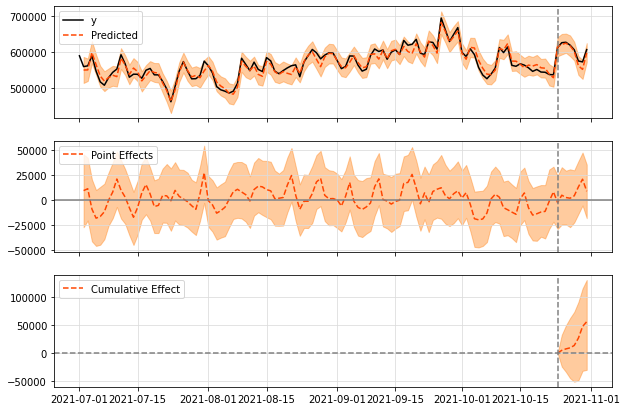

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    615619.88          4309339.0
Prediction (s.d.)         596844.19 (5109.11)4177909.5 (35763.78)
95% CI                    [586958.06, 606985.4][4108706.47, 4248897.95]

Absolute effect (s.d.)    18775.69 (5109.11) 131429.5 (35763.78)
95% CI                    [8634.48, 28661.82][60441.05, 200632.53]

Relative effect (s.d.)    3.15% (0.86%)      3.15% (0.86%)
95% CI                    [1.45%, 4.8%]      [1.45%, 4.8%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


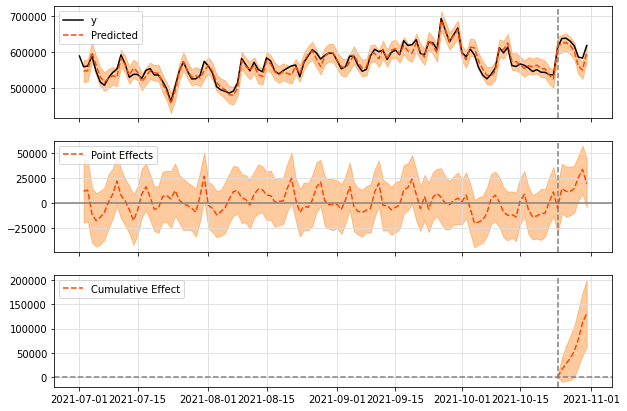

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    627573.62          4393015.5
Prediction (s.d.)         595819.0 (5571.96) 4170733.0 (39003.75)
95% CI                    [584998.3, 606839.97][4094988.06, 4247879.99]

Absolute effect (s.d.)    31754.62 (5571.96) 222282.5 (39003.75)
95% CI                    [20733.65, 42575.32][145135.51, 298027.44]

Relative effect (s.d.)    5.33% (0.94%)      5.33% (0.94%)
95% CI                    [3.48%, 7.15%]     [3.48%, 7.15%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


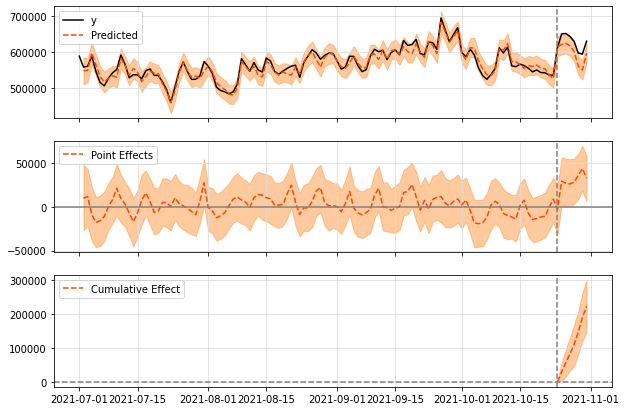

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    657458.06          4602206.5
Prediction (s.d.)         595525.62 (5427.0) 4168679.5 (37988.94)
95% CI                    [584791.19, 606064.65][4093538.53, 4242452.46]

Absolute effect (s.d.)    61932.44 (5427.0)  433527.0 (37988.94)
95% CI                    [51393.42, 72666.87][359754.04, 508667.97]

Relative effect (s.d.)    10.4% (0.91%)      10.4% (0.91%)
95% CI                    [8.63%, 12.2%]     [8.63%, 12.2%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


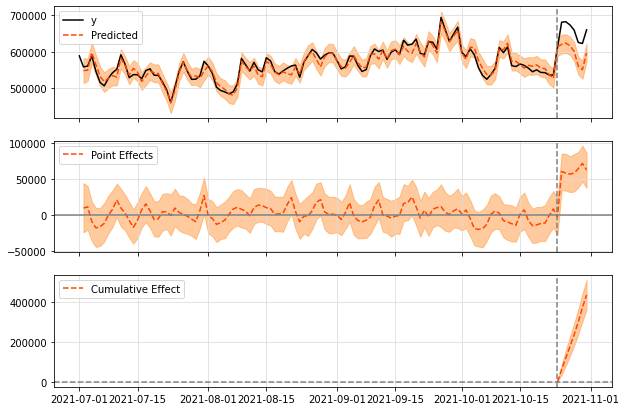

None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title Step9
# @markdown <font color='blue'><b>■ Simulate and Estimate budget</b></font>
# @markdown Simulate whether it can be said that there is a significant difference by giving a pseudo lift to the selected data frame.
# @markdown It will take about **15 minutes** to perform the simulation, since there are 12 ways of assigning the number of days[7, 14, 28] × the number of lifts[1%, 3%, 5%, 10%].

df = design.select_dataframe(
    dataframe_wide = case.df_sheet,
    your_choice = case_selection.value,
    test_col = test_selection.value,
    df_dtw_columns = design.df_dtw_columns
    )

estimation_icpa = 1000  #@param {type: "integer"}

import warnings
warnings.resetwarnings()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    design.simulate_params(
        dataframe = df,
        estimation_icpa = estimation_icpa,
        treat_duration=[7, 14, 28],
        treat_impact=[1.01, 1.03, 1.05, 1.10])

## CausalImpact Analysis Section

In [1]:
#@title Step1: Define PreProcess
#@markdown Please <font color='red'><b>run this cell</b></font> to define class PreProcess
class PreProcess(object):
  """PreProcess read, format, and check the data needed

  before Experimental Design.

  Attributes:
    load_data_from_sheet: Read data from spreadsheet.
    load_data_from_csv: Read data from CSV.
    shape_wide: Pivots the data in the specified column.
    trend_check: Visualize series data.
    _get_converted_multi_columns: Column Name Concatenation.
  """

  def __init__(self):
    pass

  def load_data_from_sheet(self, spreadsheet_url, sheet_name):
    """load_data_from_sheet read data from spreadsheet.

    Args:
      spreadsheet_url: Spreadsheet url with data.
      sheet_name: Sheet name with data.
    """
    self._workbook = gc.open_by_url(spreadsheet_url)
    self._worksheet = self._workbook.worksheet(sheet_name)
    self.df_sheet = pd.DataFrame(self._worksheet.get_all_values())
    self.df_sheet.columns = list(self.df_sheet.loc[0, :])
    self.df_sheet.drop(0, inplace=True)
    self.df_sheet.reset_index(drop=True, inplace=True)
    self.df_sheet = self.df_sheet.apply(pd.to_numeric, errors='ignore')
    self.df_sheet.replace(',', '', regex=True, inplace=True)

    self.tb_sheet = widgets.TabBar(['head', 'dtypes', 'describe'])
    with self.tb_sheet.output_to('head'):
      display(self.df_sheet.head(10))
    with self.tb_sheet.output_to('dtypes'):
      display(pd.DataFrame(self.df_sheet.dtypes, columns=['dtypes']))
    with self.tb_sheet.output_to('describe'):
      display(self.df_sheet.describe(include='all'))
    with self.tb_sheet.output_to('head'):
      pass

  def load_data_from_csv(self, csv_name):
    """load_data_from_csv read data from csv.

    Args:
      csv_name: csv file name.
    """
    uploaded = files.upload()
    self.df_sheet = pd.read_csv(io.BytesIO(uploaded[csv_name]))
    self.df_sheet = self.df_sheet.apply(pd.to_numeric, errors='ignore')
    self.df_sheet.replace(',', '', regex=True, inplace=True)

    self.tb_sheet = widgets.TabBar(['head', 'dtypes', 'describe'])
    with self.tb_sheet.output_to('head'):
      display(self.df_sheet.head(10))
    with self.tb_sheet.output_to('dtypes'):
      display(pd.DataFrame(self.df_sheet.dtypes, columns=['dtypes']))
    with self.tb_sheet.output_to('describe'):
      display(self.df_sheet.describe(include='all'))
    with self.tb_sheet.output_to('head'):
      pass

  def shape_wide(self, date_column, pivot_column, kpi_column):
    """shape_wide pivots the data in the specified column.

    Converts long data to wide data suitable for experiment design using
    fastDTW.

    Args:
      date_column: Date column name.
      pivot_column: Columns name that are pivot keys for regions, etc.
      kpi_column: KPI column name.
    """
    self._group_cols = []
    if pivot_column.count(',') == 0:
      self._group_cols.append(pivot_column)
    else:
      self._group_cols = pivot_column.replace(' ', '').split(',')

    self.df_sheet = self.df_sheet[[date_column, kpi_column, *self._group_cols
                                  ]].groupby([date_column, *self._group_cols
                                             ]).sum().reset_index()
    self.df_sheet = pd.pivot_table(
        self.df_sheet, index=date_column, columns=self._group_cols)
    self.df_sheet.columns = self.df_sheet.columns.droplevel(0)
    if len(self.df_sheet.columns.names) == 1:
      pass
    else:
      self.df_sheet.columns = self._get_converted_multi_columns(self.df_sheet)

    self.df_sheet.index = pd.to_datetime(self.df_sheet.index)
    self.df_sheet.index.rename('date', inplace=True)
    self.df_sheet.fillna(0, inplace=True)

  def _get_converted_multi_columns(self, df):
    return [col[0] + '_' + col[1] for col in df.columns.values]

  def trend_check(self, dataframe_wide):
    """trend_check visualize daily trend, 7-day moving average

    Args:
      dataframe_wide: Wide data to check the trend
    """
    self._df_long = pd.melt(
        dataframe_wide.reset_index(),
        id_vars='date').groupby('date').sum().reset_index()
    self._line = alt.Chart(self._df_long).mark_line().encode(
        x=alt.X('date', axis=alt.Axis(title='')),
        y=alt.Y('value:Q', axis=alt.Axis(title='kpi')),
        color=alt.value('#4285F4'))
    self._moving_average = alt.Chart(self._df_long).transform_window(
        rolling_mean='mean(value)',
        frame=[-7, 0],
    ).mark_line().encode(
        x=alt.X('date'), y=alt.Y('rolling_mean:Q'), color=alt.value('#DB4437'))

    self._df_scaled = dataframe_wide.copy()
    for column in self._df_scaled:
      self._df_scaled[column] = (
          self._df_scaled[column] - self._df_scaled[column].min()) / (
              self._df_scaled[column].max() - self._df_scaled[column].min())

    self._df_scaled_cols = list(self._df_scaled.columns)
    self._each = alt.Chart(self._df_scaled.reset_index()).transform_fold(
        self._df_scaled_cols, as_=['pivot', 'kpi']).mark_line().encode(
            alt.X('date:T', title=None, axis=alt.Axis(grid=False)),
            alt.Y('kpi:Q', stack=None, axis=None), alt.Color('pivot:N'),
            alt.Row(
                'pivot:N',
                title=None,
                header=alt.Header(labelAngle=0, labelAlign='left'))).properties(
                    bounds='flush',
                    height=50).configure_facet(spacing=0).configure_view(
                        stroke=None).configure_title(anchor='end')

    self._tb_trend = widgets.TabBar(['all', 'each', 'describe'])
    with self._tb_trend.output_to('all'):
      display((self._line + self._moving_average).properties(
          width=800,
          height=400,
          title={
              'text': ['Daily Trend(blue) & 7days moving average(red)'],
          }))
    with self._tb_trend.output_to('each'):
      display((self._each).properties(width=800))
    with self._tb_trend.output_to('describe'):
      display(dataframe_wide.describe(include='all'))
    with self._tb_trend.output_to('all'):
      pass

print('Done')

Done


In [2]:
#@title Step2
#@markdown Please <font color='red'><b>run this cell</b></font> to select the required items.<br>Then you will see the input fields.
print('Install tfcausalimpact')
!pip install tfcausalimpact --quiet
print('Installed')

from google.colab import auth
from google.colab import files
from google.colab import widgets
from google.auth import default

from causalimpact import CausalImpact
from IPython.display import display
from IPython.display import Markdown
from oauth2client.client import GoogleCredentials
from sklearn.metrics import mean_absolute_percentage_error

import altair as alt
import gspread
import io
import ipywidgets
import pandas as pd

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

soure_selection = ipywidgets.ToggleButtons(
    options=['google_spreadsheet', 'csv'],
    value='google_spreadsheet',
    description='data source:',
    disabled=False,
)
sheet_url = ipywidgets.Text(
    placeholder='Please enter google spreadsheet url',
    value='https://docs.google.com/spreadsheets/d/1dISrbX1mZHgzpsIct2QXFOWWRRJiCxDSmSzjuZz64Tw/edit#gid=0',
    description='sheet url:',
    disabled=False,
    layout=ipywidgets.Layout(width='1000px'))
sheet_name = ipywidgets.Text(
    placeholder='Please enter sheet name',
    value='analysis_data',
    description='sheet name:',
    disabled=False,
)
csv_name = ipywidgets.Text(
    placeholder='Please enter csv name',
    description='csv name:',
    disabled=False,
    layout=ipywidgets.Layout(width='500px'))
display(soure_selection)
display(
    Markdown(f"""<br>If you select <b>google_spreadsheet</b>,
"""), sheet_url, sheet_name, Markdown(f"""<br>If you select <b>csv</b>,
"""), csv_name)

Install tfcausalimpact
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.2 MB/s eta 0:00:00
Installed


ToggleButtons(description='data source:', options=('google_spreadsheet', 'csv'), value='google_spreadsheet')

<br>If you select <b>google_spreadsheet</b>,


Text(value='https://docs.google.com/spreadsheets/d/1dISrbX1mZHgzpsIct2QXFOWWRRJiCxDSmSzjuZz64Tw/edit#gid=0', d…

Text(value='analysis_data', description='sheet name:', placeholder='Please enter sheet name')

<br>If you select <b>csv</b>,


Text(value='', description='csv name:', layout=Layout(width='500px'), placeholder='Please enter csv name')

In [5]:
#@title Step3
#@markdown Once you have entered the above, please <font color='red'><b>run this cell</b></font> to load the file. <br> Next, please fill in the required fields in the format below.

analysis = PreProcess()
if soure_selection.value == 'google_spreadsheet':
  try:
    analysis.load_data_from_sheet(
        spreadsheet_url=sheet_url.value, sheet_name=sheet_name.value)
  except:
    print('Please check the entries in the previous cell.')
else:
  try:
    analysis.load_data_from_csv(csv_name=csv_name.value)
  except:
    print('Please check the entries in the previous cell.')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,date,test,ctrl
0,2021-07-01,115133,70628
1,2021-07-02,108481,65315
2,2021-07-03,106624,66472
3,2021-07-04,112356,69235
4,2021-07-05,107549,68778
5,2021-07-06,102172,61492
6,2021-07-07,98457,61233
7,2021-07-08,101844,63740
8,2021-07-09,108816,64068
9,2021-07-10,108681,65006


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,dtypes
date,object
test,int64
ctrl,int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,date,test,ctrl
count,123,123.000000,123.000000
unique,123,NaN,NaN
top,2021-07-01,NaN,NaN
freq,1,NaN,NaN
mean,NaN,112245.113821,67770.512195
std,NaN,8701.470348,4794.140107
min,NaN,91980.000000,55840.000000
25%,NaN,106352.000000,64547.500000
50%,NaN,111788.000000,67583.000000
75%,NaN,117803.000000,70956.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


MAPE: 1.94%
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    118853.94          3684472.0
Prediction (s.d.)         111284.9 (868.19)  3449831.75 (26914.0)
95% CI                    [109595.17, 112998.43][3397450.38, 3502951.35]

Absolute effect (s.d.)    7569.04 (868.19)   234640.25 (26914.0)
95% CI                    [5855.51, 9258.77] [181520.65, 287021.62]

Relative effect (s.d.)    6.8% (0.78%)       6.8% (0.78%)
95% CI                    [5.26%, 8.32%]     [5.26%, 8.32%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


/usr/local/lib/python3.8/dist-packages/jinja2/environment.py:1088: DeprecationWarning: 'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.
  return concat(self.root_render_func(self.new_context(vars)))
/usr/local/lib/python3.8/dist-packages/jinja2/runtime.py:679: DeprecationWarning: 'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.
  rv = self._func(*arguments)


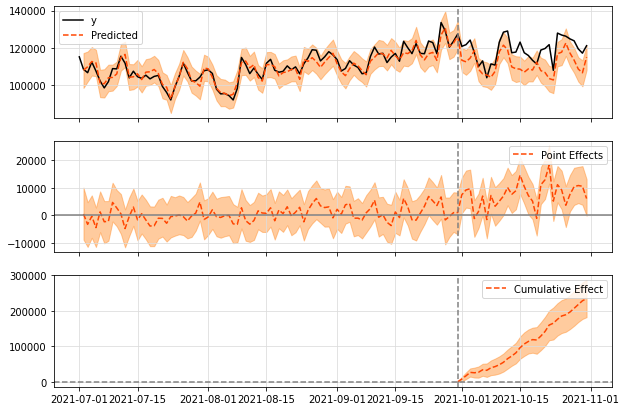

In [6]:
#@title Step4
#@markdown Once you have entered the above, please <font color='red'><b>run this cell</b></font> to load the file. <br> Next, please fill in the required fields in the format below.

date_col = 'date'  #@param {type: "string"}
pre_period_start = "2021-07-01" #@param {type:"date"}
pre_period_end = "2021-09-30" #@param {type:"date"}
post_period_start = "2021-10-01" #@param {type:"date"}
post_period_end = "2021-10-31" #@param {type:"date"}

if analysis.df_sheet.index.name != date_col:
  analysis.df_sheet.set_index(date_col, inplace=True)
  analysis.df_sheet.index = analysis.df_sheet.index.map(str)
else:
  pass

pre_period = [pre_period_start, pre_period_end]
post_period = [post_period_start, post_period_end]

import warnings
warnings.resetwarnings()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ci = CausalImpact(analysis.df_sheet, pre_period, post_period)

mape = mean_absolute_percentage_error(
                ci.data.test[ci.pre_period[0]:ci.pre_period[1]],
                ci.inferences.complete_preds_means[ci.pre_period[0]:ci.pre_period[1]])
print('MAPE: {0:.2%}'.format(mape))
print(ci.summary())
ci.plot()
